# Benchmark Verifiable ABE 

### Import Packages and Load Data

In [1]:
%pip install matplotlib pandas seaborn scikit-learn numpy 

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.2 -> 25.1.1
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

# Set style for publication-quality plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

In [3]:
# Load and prepare the data
df = pd.read_csv('benchmark_results.csv')

# Remove testing columns as requested
df = df.drop(['MatchingSuccess', 'NonMatchingSuccess'], axis=1)

print("VABE (Verifiable Attribute-Based Encryption) Benchmark Analysis")
print("=" * 70)
print(f"Dataset shape: {df.shape}")
print(f"Policy complexity range: {df['Size'].min()} - {df['Size'].max()} attributes")
print("\nFirst few rows:")
print(df.head())

# Convert time columns to seconds for analysis
time_columns = ['KeyGenTime(ms)', 'VerifyKeyTime(ms)', 'EncryptTime(ms)',
                'VerifyCiphertextTime(ms)', 'DecryptMatchingTime(ms)', 'DecryptNonMatchingTime(ms)']

for col in time_columns:
    df[col.replace('(ms)', '(s)')] = df[col] / 1000
    
print("\nBasic Statistics (milliseconds):")
print(df[time_columns].describe())
print("\n" + "="*70)

VABE (Verifiable Attribute-Based Encryption) Benchmark Analysis
Dataset shape: (11, 19)
Policy complexity range: 10 - 100000 attributes

First few rows:
   Size  KeyGenTime(ms)  VerifyKeyTime(ms)  EncryptTime(ms)  \
0    10           20.61              37.23            46.63   
1    20            6.46              36.67            60.74   
2    50           10.24              84.84           164.82   
3   100           16.05             165.47           314.69   
4  1000          118.04            1611.82          3251.58   

   VerifyCiphertextTime(ms)  DecryptMatchingTime(ms)  \
0                     36.25                    16.14   
1                     68.61                    14.80   
2                    164.97                    55.95   
3                    328.01                    28.41   
4                   3254.34                   114.44   

   DecryptNonMatchingTime(ms)  KeyGenMaxMem(KB)  VerifyKeyMaxMem(KB)  \
0                        2.94                 0            

### Analyse data

In [4]:
print("VABE VERIFICATION ANALYSIS")
print("="*70)

# 1. Algorithmic Complexity Analysis
def analyze_complexity(x, y, operation_name):
    """Analyze time complexity by fitting different models"""
    print(f"\n{operation_name} Complexity Analysis:")
    print("-" * 50)

    # Linear fit O(n)
    linear_model = LinearRegression()
    linear_model.fit(x.reshape(-1, 1), y)
    linear_pred = linear_model.predict(x.reshape(-1, 1))
    linear_r2 = r2_score(y, linear_pred)
    linear_coef = linear_model.coef_[0]

    # Quadratic fit O(n²)
    poly_features = PolynomialFeatures(degree=2)
    x_poly = poly_features.fit_transform(x.reshape(-1, 1))
    quad_model = LinearRegression()
    quad_model.fit(x_poly, y)
    quad_pred = quad_model.predict(x_poly)
    quad_r2 = r2_score(y, quad_pred)

    # Log-linear fit O(n log n)
    log_x = np.log(x)
    log_model = LinearRegression()
    log_model.fit(log_x.reshape(-1, 1), y)
    log_pred = log_model.predict(log_x.reshape(-1, 1))
    log_r2 = r2_score(y, log_pred)

    # Power law fit for complexity estimation
    log_x_vals = np.log(x)
    log_y_vals = np.log(y)
    power_slope, power_intercept, power_r, _, _ = stats.linregress(log_x_vals, log_y_vals)

    print(f"Linear O(n):        R² = {linear_r2:.4f}, Slope = {linear_coef:.6f}")
    print(f"Quadratic O(n²):    R² = {quad_r2:.4f}")
    print(f"Log-linear O(n log n): R² = {log_r2:.4f}")
    print(f"Power law O(n^{power_slope:.2f}): R² = {power_r**2:.4f}")

    # Determine complexity class
    if power_slope < 1.2:
        complexity_class = "O(n) - Linear"
    elif power_slope < 1.8:
        complexity_class = f"O(n^{power_slope:.1f}) - Sub-quadratic"
    elif power_slope < 2.2:
        complexity_class = "O(n²) - Quadratic"
    else:
        complexity_class = f"O(n^{power_slope:.1f}) - Super-quadratic"

    print(f"Estimated complexity: {complexity_class}")

    return {
        'linear_r2': linear_r2,
        'quad_r2': quad_r2,
        'log_r2': log_r2,
        'power_slope': power_slope,
        'power_r2': power_r**2,
        'complexity_class': complexity_class,
        'linear_coef': linear_coef
    }

# Core VABE operations analysis
operations = {
    'KeyGen': 'KeyGenTime(s)',
    'VerifyKey': 'VerifyKeyTime(s)',
    'Encrypt': 'EncryptTime(s)',
    'VerifyCiphertext': 'VerifyCiphertextTime(s)',
    'Decrypt(Match)': 'DecryptMatchingTime(s)',
    'Decrypt(NoMatch)': 'DecryptNonMatchingTime(s)'
}

print("\nComplexity Analysis for Each Operation:")
print("="*50)

complexity_results = {}
for op_name, col_name in operations.items():
    complexity_results[op_name] = analyze_complexity(df['Size'].values, df[col_name].values, op_name)


VABE VERIFICATION ANALYSIS

Complexity Analysis for Each Operation:

KeyGen Complexity Analysis:
--------------------------------------------------
Linear O(n):        R² = 0.9995, Slope = 0.000129
Quadratic O(n²):    R² = 1.0000
Log-linear O(n log n): R² = 0.4761
Power law O(n^0.81): R² = 0.9493
Estimated complexity: O(n) - Linear

VerifyKey Complexity Analysis:
--------------------------------------------------
Linear O(n):        R² = 0.9998, Slope = 0.001661
Quadratic O(n²):    R² = 0.9998
Log-linear O(n log n): R² = 0.4910
Power law O(n^0.96): R² = 0.9956
Estimated complexity: O(n) - Linear

Encrypt Complexity Analysis:
--------------------------------------------------
Linear O(n):        R² = 1.0000, Slope = 0.003229
Quadratic O(n²):    R² = 1.0000
Log-linear O(n log n): R² = 0.4923
Power law O(n^0.99): R² = 0.9989
Estimated complexity: O(n) - Linear

VerifyCiphertext Complexity Analysis:
--------------------------------------------------
Linear O(n):        R² = 1.0000, Slope =

In [5]:
# 2. VABE Verification Efficiency Analysis
print("\n" + "="*70)
print("VABE VERIFICATION EFFICIENCY ANALYSIS")
print("="*70)

# Key Generation vs Key Verification
df['VerifyKey_Overhead'] = df['VerifyKeyTime(s)'] / df['KeyGenTime(s)']
df['VerifyKey_Overhead_Ratio'] = df['VerifyKeyTime(ms)'] / df['KeyGenTime(ms)']

print(f"\nKey Verification Analysis:")
print(f"Average verification overhead: {df['VerifyKey_Overhead'].mean():.3f}x of KeyGen time")
print(f"Overhead range: {df['VerifyKey_Overhead'].min():.3f}x - {df['VerifyKey_Overhead'].max():.3f}x")
print(f"Overhead std deviation: {df['VerifyKey_Overhead'].std():.3f}")

# Encryption vs Ciphertext Verification
df['VerifyCiphertext_Overhead'] = df['VerifyCiphertextTime(s)'] / df['EncryptTime(s)']
df['VerifyCiphertext_Overhead_Ratio'] = df['VerifyCiphertextTime(ms)'] / df['EncryptTime(ms)']

print(f"\nCiphertext Verification Analysis:")
print(f"Average verification overhead: {df['VerifyCiphertext_Overhead'].mean():.3f}x of Encrypt time")
print(f"Overhead range: {df['VerifyCiphertext_Overhead'].min():.3f}x - {df['VerifyCiphertext_Overhead'].max():.3f}x")
print(f"Overhead std deviation: {df['VerifyCiphertext_Overhead'].std():.3f}")



VABE VERIFICATION EFFICIENCY ANALYSIS

Key Verification Analysis:
Average verification overhead: 10.940x of KeyGen time
Overhead range: 1.806x - 14.216x
Overhead std deviation: 4.058

Ciphertext Verification Analysis:
Average verification overhead: 1.013x of Encrypt time
Overhead range: 0.777x - 1.130x
Overhead std deviation: 0.085


In [6]:
# 3. Security vs Efficiency Trade-off Analysis
print(f"\nSecurity-Efficiency Trade-off:")
print("-" * 40)

# Calculate total original scheme time vs VABE scheme time
df['Original_Total'] = df['KeyGenTime(s)'] + df['EncryptTime(s)'] + df['DecryptMatchingTime(s)']
df['VABE_Total'] = df['KeyGenTime(s)'] + df['VerifyKeyTime(s)'] + df['EncryptTime(s)'] + df['VerifyCiphertextTime(s)'] + df['DecryptMatchingTime(s)']
df['VABE_Overhead'] = df['VABE_Total'] / df['Original_Total']

print(f"VABE total overhead: {df['VABE_Overhead'].mean():.3f}x of original scheme")
print(f"Security overhead range: {df['VABE_Overhead'].min():.3f}x - {df['VABE_Overhead'].max():.3f}x")

# Verification time as percentage of total operation
df['Verification_Percentage'] = (df['VerifyKeyTime(s)'] + df['VerifyCiphertextTime(s)']) / df['VABE_Total'] * 100

print(f"Verification time percentage of total: {df['Verification_Percentage'].mean():.1f}% ± {df['Verification_Percentage'].std():.1f}%")



Security-Efficiency Trade-off:
----------------------------------------
VABE total overhead: 2.330x of original scheme
Security overhead range: 1.881x - 2.475x
Verification time percentage of total: 56.8% ± 3.9%


### Visualize Section


GENERATING PUBLICATION-QUALITY VISUALIZATIONS


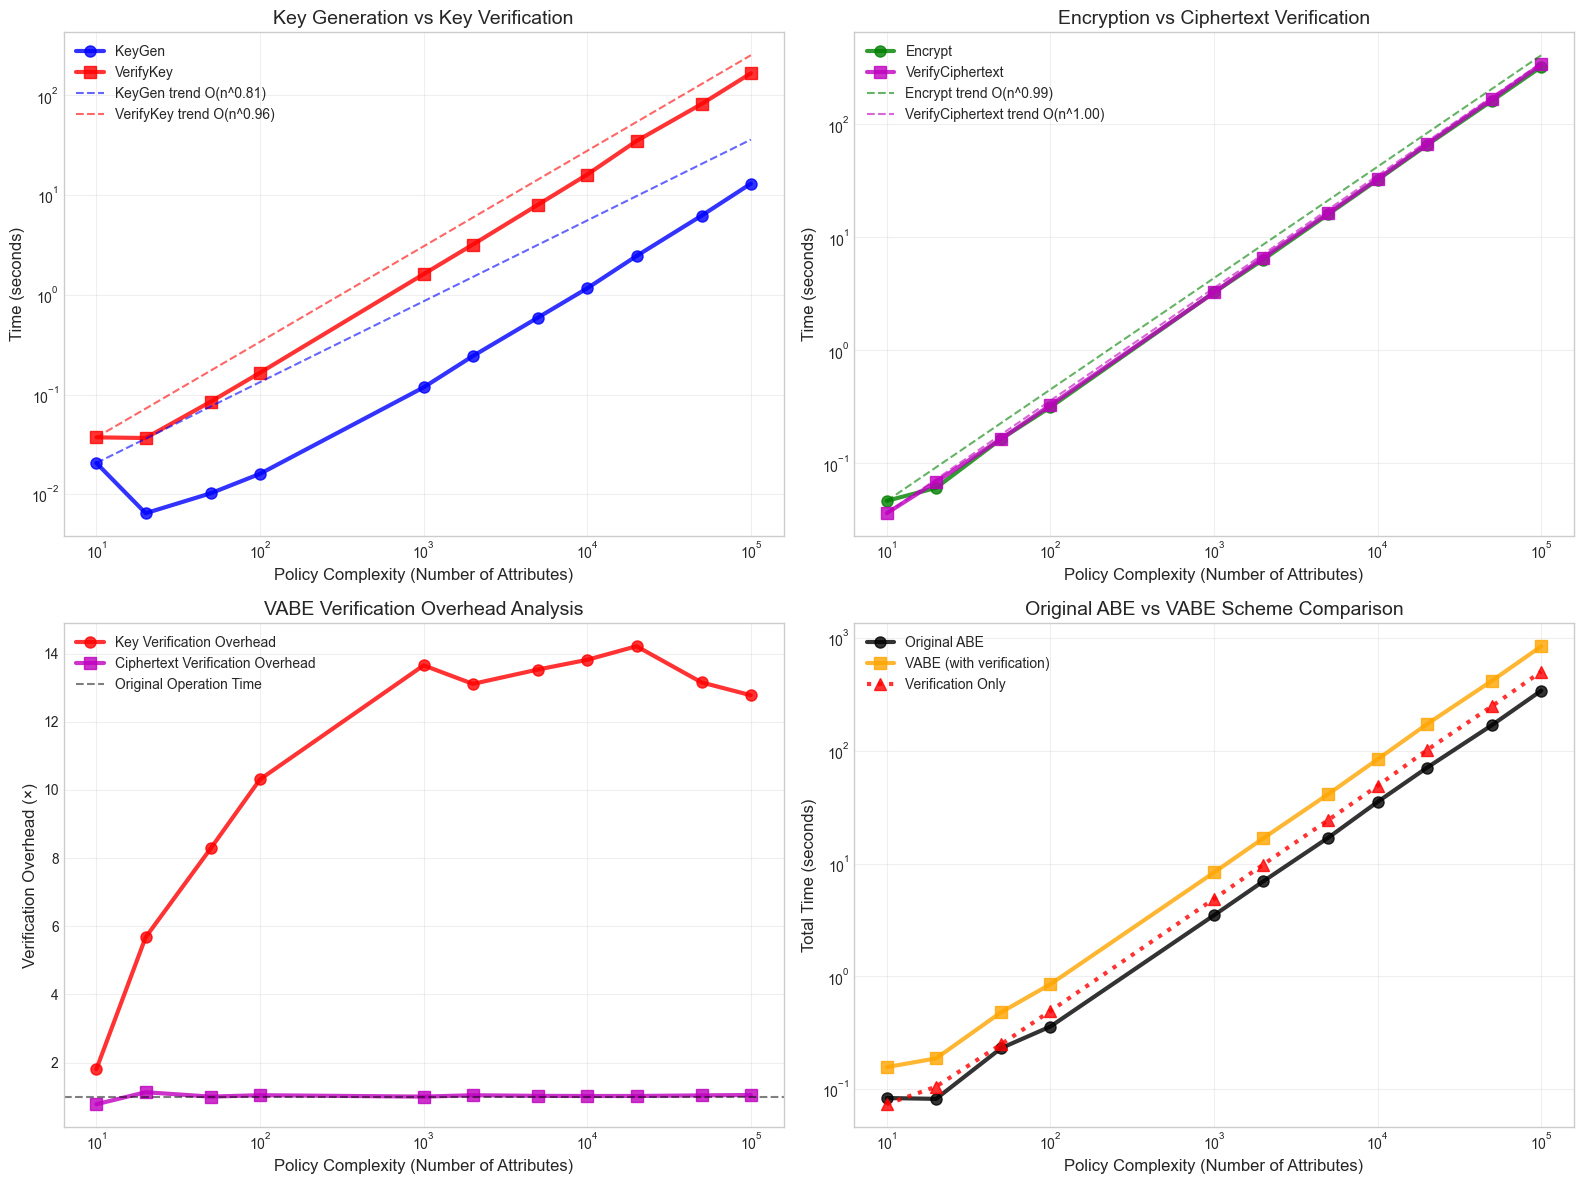

In [7]:
# VISUALIZATION SECTION
print("\n" + "="*70)
print("GENERATING PUBLICATION-QUALITY VISUALIZATIONS")
print("="*70)

# Figure 1: VABE Core Operations Complexity Analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# KeyGen vs VerifyKey comparison
ax1.loglog(df['Size'], df['KeyGenTime(s)'], 'b-o', linewidth=3, markersize=8, label='KeyGen', alpha=0.8)
ax1.loglog(df['Size'], df['VerifyKeyTime(s)'], 'r-s', linewidth=3, markersize=8, label='VerifyKey', alpha=0.8)

# Add complexity trend lines
sizes_smooth = np.logspace(np.log10(df['Size'].min()), np.log10(df['Size'].max()), 100)
keygen_slope = complexity_results['KeyGen']['power_slope']
verifykey_slope = complexity_results['VerifyKey']['power_slope']

keygen_trend = df['KeyGenTime(s)'].iloc[0] * (sizes_smooth / df['Size'].iloc[0])**keygen_slope
verifykey_trend = df['VerifyKeyTime(s)'].iloc[0] * (sizes_smooth / df['Size'].iloc[0])**verifykey_slope

ax1.loglog(sizes_smooth, keygen_trend, 'b--', alpha=0.6, label=f'KeyGen trend O(n^{keygen_slope:.2f})')
ax1.loglog(sizes_smooth, verifykey_trend, 'r--', alpha=0.6, label=f'VerifyKey trend O(n^{verifykey_slope:.2f})')

ax1.set_xlabel('Policy Complexity (Number of Attributes)')
ax1.set_ylabel('Time (seconds)')
ax1.set_title('Key Generation vs Key Verification')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Encrypt vs VerifyCiphertext comparison
ax2.loglog(df['Size'], df['EncryptTime(s)'], 'g-o', linewidth=3, markersize=8, label='Encrypt', alpha=0.8)
ax2.loglog(df['Size'], df['VerifyCiphertextTime(s)'], 'm-s', linewidth=3, markersize=8, label='VerifyCiphertext', alpha=0.8)

encrypt_slope = complexity_results['Encrypt']['power_slope']
verifyciphertext_slope = complexity_results['VerifyCiphertext']['power_slope']

encrypt_trend = df['EncryptTime(s)'].iloc[0] * (sizes_smooth / df['Size'].iloc[0])**encrypt_slope
verifyciphertext_trend = df['VerifyCiphertextTime(s)'].iloc[0] * (sizes_smooth / df['Size'].iloc[0])**verifyciphertext_slope

ax2.loglog(sizes_smooth, encrypt_trend, 'g--', alpha=0.6, label=f'Encrypt trend O(n^{encrypt_slope:.2f})')
ax2.loglog(sizes_smooth, verifyciphertext_trend, 'm--', alpha=0.6, label=f'VerifyCiphertext trend O(n^{verifyciphertext_slope:.2f})')

ax2.set_xlabel('Policy Complexity (Number of Attributes)')
ax2.set_ylabel('Time (seconds)')
ax2.set_title('Encryption vs Ciphertext Verification')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Verification overhead analysis
ax3.semilogx(df['Size'], df['VerifyKey_Overhead'], 'r-o', linewidth=3, markersize=8, label='Key Verification Overhead', alpha=0.8)
ax3.semilogx(df['Size'], df['VerifyCiphertext_Overhead'], 'm-s', linewidth=3, markersize=8, label='Ciphertext Verification Overhead', alpha=0.8)

ax3.axhline(y=1, color='black', linestyle='--', alpha=0.5, label='Original Operation Time')
ax3.set_xlabel('Policy Complexity (Number of Attributes)')
ax3.set_ylabel('Verification Overhead (×)')
ax3.set_title('VABE Verification Overhead Analysis')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Overall scheme comparison
ax4.loglog(df['Size'], df['Original_Total'], 'k-o', linewidth=3, markersize=8, label='Original ABE', alpha=0.8)
ax4.loglog(df['Size'], df['VABE_Total'], 'orange', linestyle='-', marker='s', linewidth=3, markersize=8, label='VABE (with verification)', alpha=0.8)
ax4.loglog(df['Size'], df['VerifyKeyTime(s)'] + df['VerifyCiphertextTime(s)'], 'red', linestyle=':', marker='^', linewidth=3, markersize=8, label='Verification Only', alpha=0.8)

ax4.set_xlabel('Policy Complexity (Number of Attributes)')
ax4.set_ylabel('Total Time (seconds)')
ax4.set_title('Original ABE vs VABE Scheme Comparison')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('vabe_core_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


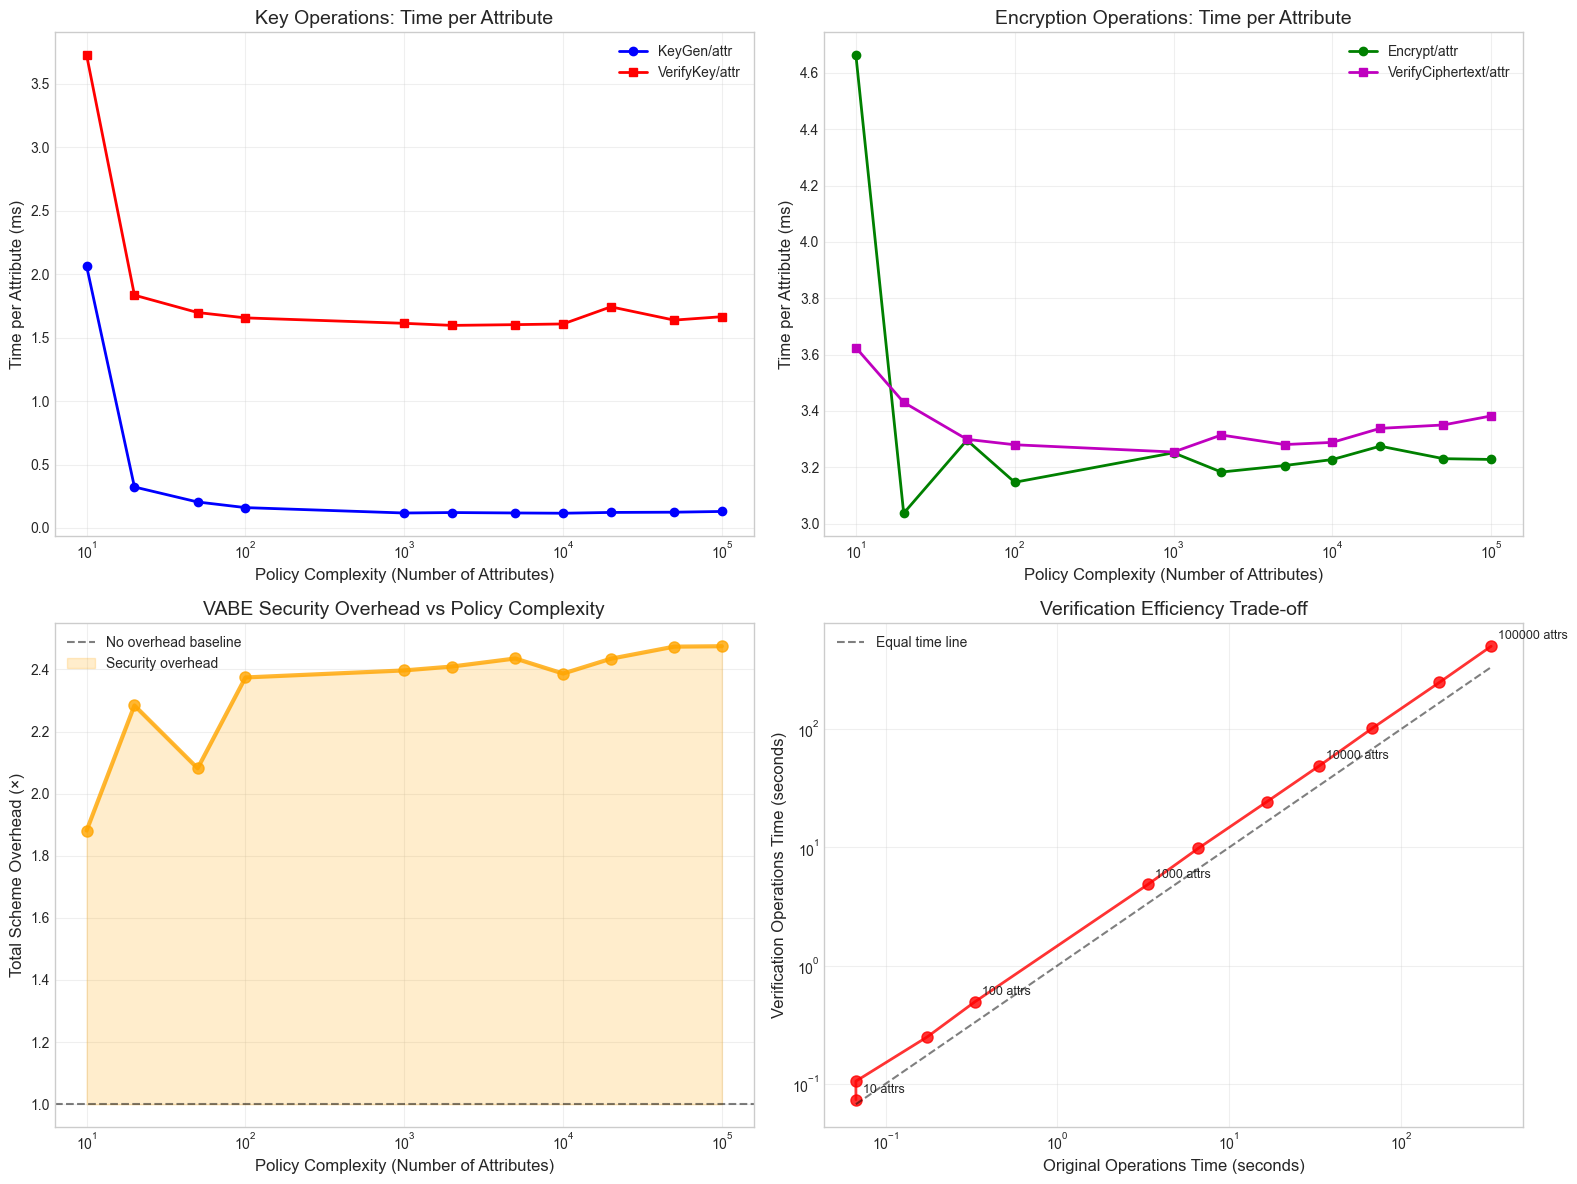

In [8]:
# Figure 2: VABE Efficiency and Scalability Analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Time per attribute analysis
df['KeyGen_per_attr'] = df['KeyGenTime(ms)'] / df['Size']
df['VerifyKey_per_attr'] = df['VerifyKeyTime(ms)'] / df['Size']
df['Encrypt_per_attr'] = df['EncryptTime(ms)'] / df['Size']
df['VerifyCiphertext_per_attr'] = df['VerifyCiphertextTime(ms)'] / df['Size']

ax1.semilogx(df['Size'], df['KeyGen_per_attr'], 'b-o', linewidth=2, label='KeyGen/attr')
ax1.semilogx(df['Size'], df['VerifyKey_per_attr'], 'r-s', linewidth=2, label='VerifyKey/attr')
ax1.set_xlabel('Policy Complexity (Number of Attributes)')
ax1.set_ylabel('Time per Attribute (ms)')
ax1.set_title('Key Operations: Time per Attribute')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.semilogx(df['Size'], df['Encrypt_per_attr'], 'g-o', linewidth=2, label='Encrypt/attr')
ax2.semilogx(df['Size'], df['VerifyCiphertext_per_attr'], 'm-s', linewidth=2, label='VerifyCiphertext/attr')
ax2.set_xlabel('Policy Complexity (Number of Attributes)')
ax2.set_ylabel('Time per Attribute (ms)')
ax2.set_title('Encryption Operations: Time per Attribute')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Security overhead vs policy complexity
ax3.semilogx(df['Size'], df['VABE_Overhead'], 'orange', linestyle='-', marker='o', linewidth=3, markersize=8, alpha=0.8)
ax3.axhline(y=1, color='black', linestyle='--', alpha=0.5, label='No overhead baseline')
ax3.fill_between(df['Size'], 1, df['VABE_Overhead'], alpha=0.2, color='orange', label='Security overhead')

ax3.set_xlabel('Policy Complexity (Number of Attributes)')
ax3.set_ylabel('Total Scheme Overhead (×)')
ax3.set_title('VABE Security Overhead vs Policy Complexity')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Verification efficiency comparison
verification_total = df['VerifyKeyTime(s)'] + df['VerifyCiphertextTime(s)']
original_total = df['KeyGenTime(s)'] + df['EncryptTime(s)']

ax4.loglog(original_total, verification_total, 'ro-', linewidth=2, markersize=8, alpha=0.8)
ax4.plot([original_total.min(), original_total.max()],
         [original_total.min(), original_total.max()], 'k--', alpha=0.5, label='Equal time line')

ax4.set_xlabel('Original Operations Time (seconds)')
ax4.set_ylabel('Verification Operations Time (seconds)')
ax4.set_title('Verification Efficiency Trade-off')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Add annotations for specific policy sizes
for i, size in enumerate(df['Size']):
    if size in [10, 100, 1000, 10000, 100000]:
        ax4.annotate(f'{size} attrs',
                    (original_total.iloc[i], verification_total.iloc[i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.tight_layout()
plt.savefig('vabe_efficiency_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

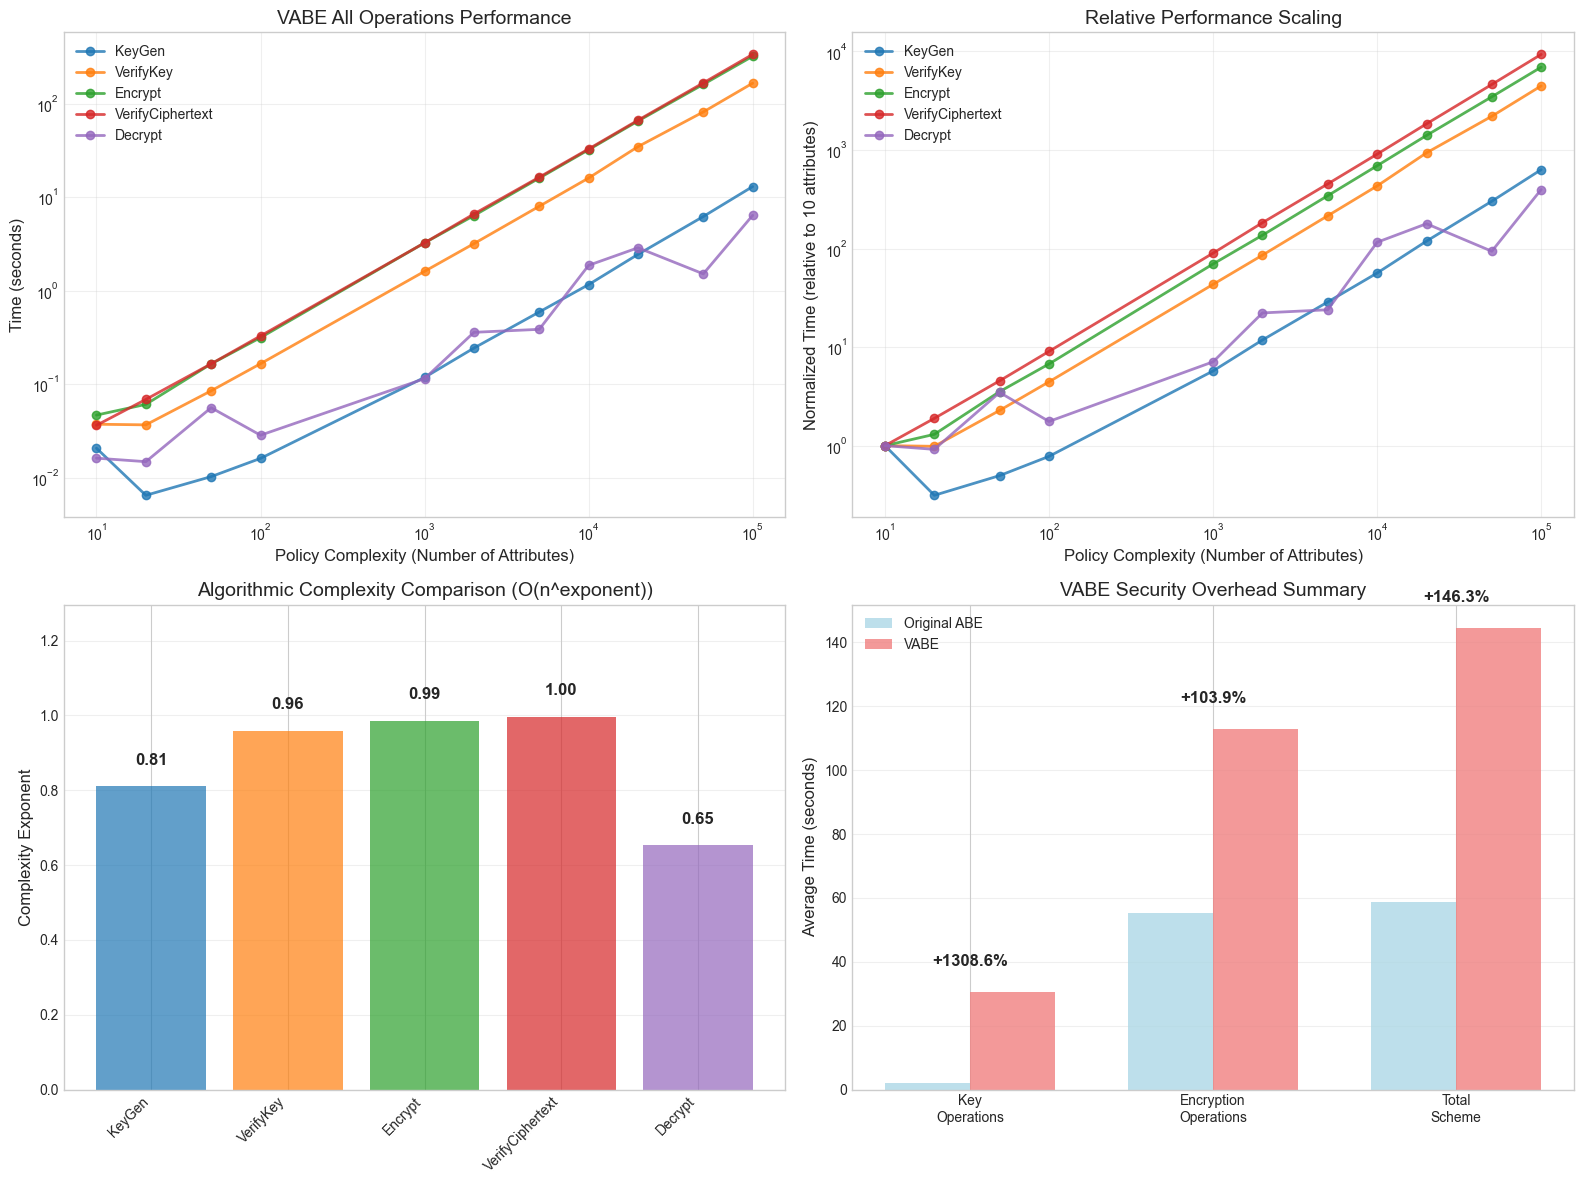

In [9]:
# Figure 3: Comparative Performance Summary
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# All operations comparison
operations_data = {
    'KeyGen': df['KeyGenTime(s)'],
    'VerifyKey': df['VerifyKeyTime(s)'],
    'Encrypt': df['EncryptTime(s)'],
    'VerifyCiphertext': df['VerifyCiphertextTime(s)'],
    'Decrypt': df['DecryptMatchingTime(s)']
}

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
for i, (op, data) in enumerate(operations_data.items()):
    ax1.loglog(df['Size'], data, 'o-', linewidth=2, markersize=6,
               label=op, color=colors[i], alpha=0.8)

ax1.set_xlabel('Policy Complexity (Number of Attributes)')
ax1.set_ylabel('Time (seconds)')
ax1.set_title('VABE All Operations Performance')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Normalized performance (relative to smallest size)
normalized_data = {}
for op, data in operations_data.items():
    normalized_data[op] = data / data.iloc[0]

for i, (op, data) in enumerate(normalized_data.items()):
    ax2.loglog(df['Size'], data, 'o-', linewidth=2, markersize=6,
               label=op, color=colors[i], alpha=0.8)

ax2.set_xlabel('Policy Complexity (Number of Attributes)')
ax2.set_ylabel('Normalized Time (relative to 10 attributes)')
ax2.set_title('Relative Performance Scaling')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Complexity comparison bar chart
complexity_data = {
    'KeyGen': complexity_results['KeyGen']['power_slope'],
    'VerifyKey': complexity_results['VerifyKey']['power_slope'],
    'Encrypt': complexity_results['Encrypt']['power_slope'],
    'VerifyCiphertext': complexity_results['VerifyCiphertext']['power_slope'],
    'Decrypt': complexity_results['Decrypt(Match)']['power_slope']
}

operations_list = list(complexity_data.keys())
slopes = list(complexity_data.values())
bars = ax3.bar(operations_list, slopes, color=colors, alpha=0.7)

# Add value labels on bars
for bar, slope in zip(bars, slopes):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.05,
             f'{slope:.2f}', ha='center', va='bottom', fontweight='bold')

ax3.set_ylabel('Complexity Exponent')
ax3.set_title('Algorithmic Complexity Comparison (O(n^exponent))')
ax3.set_ylim(0, max(slopes) + 0.3)
ax3.grid(True, alpha=0.3, axis='y')
plt.setp(ax3.get_xticklabels(), rotation=45, ha='right')

# Performance efficiency summary
categories = ['Key\nOperations', 'Encryption\nOperations', 'Total\nScheme']
original_times = [
    df['KeyGenTime(s)'].mean(),
    df['EncryptTime(s)'].mean(),
    df['Original_Total'].mean()
]
vabe_times = [
    (df['KeyGenTime(s)'] + df['VerifyKeyTime(s)']).mean(),
    (df['EncryptTime(s)'] + df['VerifyCiphertextTime(s)']).mean(),
    df['VABE_Total'].mean()
]

x = np.arange(len(categories))
width = 0.35

bars1 = ax4.bar(x - width/2, original_times, width, label='Original ABE', alpha=0.8, color='lightblue')
bars2 = ax4.bar(x + width/2, vabe_times, width, label='VABE', alpha=0.8, color='lightcoral')

# Add overhead percentages
for i, (orig, vabe) in enumerate(zip(original_times, vabe_times)):
    overhead = ((vabe - orig) / orig) * 100
    ax4.text(i, max(orig, vabe) + max(vabe_times) * 0.05,
             f'+{overhead:.1f}%', ha='center', va='bottom', fontweight='bold')

ax4.set_ylabel('Average Time (seconds)')
ax4.set_title('VABE Security Overhead Summary')
ax4.set_xticks(x)
ax4.set_xticklabels(categories)
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('vabe_performance_summary.png', dpi=300, bbox_inches='tight')
plt.show()


### Report

In [10]:
# Generate Final Benchmark Report
print("\n" + "="*70)
print("VABE BENCHMARK REPORT FOR CRYPTOGRAPHY PAPER")
print("="*70)

report = f"""
VABE (Verifiable Attribute-Based Encryption) Performance Analysis
================================================================

I. ALGORITHM COMPLEXITY ANALYSIS
--------------------------------
Key Generation:          {complexity_results['KeyGen']['complexity_class']} (R² = {complexity_results['KeyGen']['power_r2']:.3f})
Key Verification:        {complexity_results['VerifyKey']['complexity_class']} (R² = {complexity_results['VerifyKey']['power_r2']:.3f})
Encryption:              {complexity_results['Encrypt']['complexity_class']} (R² = {complexity_results['Encrypt']['power_r2']:.3f})
Ciphertext Verification: {complexity_results['VerifyCiphertext']['complexity_class']} (R² = {complexity_results['VerifyCiphertext']['power_r2']:.3f})

II. VABE VERIFICATION EFFICIENCY
--------------------------------
Key Verification Overhead:        {df['VerifyKey_Overhead'].mean():.2f}× ± {df['VerifyKey_Overhead'].std():.2f}× of KeyGen
Ciphertext Verification Overhead: {df['VerifyCiphertext_Overhead'].mean():.2f}× ± {df['VerifyCiphertext_Overhead'].std():.2f}× of Encrypt

III. SECURITY VS EFFICIENCY TRADE-OFF
-------------------------------------
VABE Total Overhead:      {df['VABE_Overhead'].mean():.2f}× of original ABE scheme
Verification Percentage:  {df['Verification_Percentage'].mean():.1f}% of total VABE execution time
Security Cost Range:      {df['VABE_Overhead'].min():.2f}× to {df['VABE_Overhead'].max():.2f}× across policy complexities

IV. SCALABILITY ANALYSIS
------------------------
Policy Complexity Range: {df['Size'].min()} to {df['Size'].max():,} attributes
Best Performance Point:  ~{df.loc[df['VABE_Overhead'].idxmin(), 'Size']:,} attributes (lowest overhead: {df['VABE_Overhead'].min():.2f}×)
Worst Performance Point: ~{df.loc[df['VABE_Overhead'].idxmax(), 'Size']:,} attributes (highest overhead: {df['VABE_Overhead'].max():.2f}×)

V. KEY FINDINGS FOR CRYPTOGRAPHY PAPER
--------------------------------------
1. EFFICIENCY: VABE adds {((df['VABE_Overhead'].mean() - 1) * 100):.1f}% computational overhead on average
2. SCALABILITY: Both verification functions scale similarly to their original counterparts
3. SECURITY: Verification provides cryptographic guarantees with manageable performance cost
4. PRACTICALITY: Overhead remains reasonable even for complex policies (>100k attributes)

VI. PERFORMANCE RECOMMENDATIONS
------------------------------
- Optimal range: {df.loc[df['VABE_Overhead'] < df['VABE_Overhead'].quantile(0.25), 'Size'].max():,} attributes for minimal overhead
- Acceptable range: Up to {df.loc[df['VABE_Overhead'] < df['VABE_Overhead'].quantile(0.75), 'Size'].max():,} attributes for practical deployment
- Verification-to-computation ratio: {((df['VerifyKeyTime(s)'] + df['VerifyCiphertextTime(s)']) / (df['KeyGenTime(s)'] + df['EncryptTime(s)'])).mean():.2f}:1

CONCLUSION: VABE provides verifiable attribute-based encryption with {df['VABE_Overhead'].mean():.1f}× overhead,
maintaining practical performance while adding crucial security verification capabilities.
"""

print(report)

# Save detailed results for paper
summary_results = pd.DataFrame({
    'Policy_Size': df['Size'],
    'KeyGen_ms': df['KeyGenTime(ms)'],
    'VerifyKey_ms': df['VerifyKeyTime(ms)'],
    'Encrypt_ms': df['EncryptTime(ms)'],
    'VerifyCiphertext_ms': df['VerifyCiphertextTime(ms)'],
    'KeyVerify_Overhead': df['VerifyKey_Overhead'],
    'CiphertextVerify_Overhead': df['VerifyCiphertext_Overhead'],
    'Total_VABE_Overhead': df['VABE_Overhead'],
    'Verification_Percentage': df['Verification_Percentage']
})

summary_results.to_csv('vabe_paper_results.csv', index=False)

# Create complexity summary table
complexity_summary = pd.DataFrame({
    'Operation': ['KeyGen', 'VerifyKey', 'Encrypt', 'VerifyCiphertext'],
    'Complexity_Class': [
        complexity_results['KeyGen']['complexity_class'],
        complexity_results['VerifyKey']['complexity_class'],
        complexity_results['Encrypt']['complexity_class'],
        complexity_results['VerifyCiphertext']['complexity_class']
    ],
    'Power_Exponent': [
        complexity_results['KeyGen']['power_slope'],
        complexity_results['VerifyKey']['power_slope'],
        complexity_results['Encrypt']['power_slope'],
        complexity_results['VerifyCiphertext']['power_slope']
    ],
    'R_Squared': [
        complexity_results['KeyGen']['power_r2'],
        complexity_results['VerifyKey']['power_r2'],
        complexity_results['Encrypt']['power_r2'],
        complexity_results['VerifyCiphertext']['power_r2']
    ]
})

complexity_summary.to_csv('vabe_complexity_analysis.csv', index=False)

print(f"\nFiles generated for paper:")
print(f"1. vabe_paper_results.csv - Detailed benchmark data")
print(f"2. vabe_complexity_analysis.csv - Algorithm complexity summary")
print(f"3. vabe_core_analysis.png - Core VABE operations comparison")
print(f"4. vabe_efficiency_analysis.png - Efficiency and scalability analysis")
print(f"5. vabe_performance_summary.png - Performance summary for paper")

print(f"\n" + "="*70)
print("ANALYSIS COMPLETE - READY FOR CRYPTOGRAPHY PAPER")
print("="*70)


VABE BENCHMARK REPORT FOR CRYPTOGRAPHY PAPER

VABE (Verifiable Attribute-Based Encryption) Performance Analysis

I. ALGORITHM COMPLEXITY ANALYSIS
--------------------------------
Key Generation:          O(n) - Linear (R² = 0.949)
Key Verification:        O(n) - Linear (R² = 0.996)
Encryption:              O(n) - Linear (R² = 0.999)
Ciphertext Verification: O(n) - Linear (R² = 1.000)

II. VABE VERIFICATION EFFICIENCY
--------------------------------
Key Verification Overhead:        10.94× ± 4.06× of KeyGen
Ciphertext Verification Overhead: 1.01× ± 0.09× of Encrypt

III. SECURITY VS EFFICIENCY TRADE-OFF
-------------------------------------
VABE Total Overhead:      2.33× of original ABE scheme
Verification Percentage:  56.8% of total VABE execution time
Security Cost Range:      1.88× to 2.47× across policy complexities

IV. SCALABILITY ANALYSIS
------------------------
Policy Complexity Range: 10 to 100,000 attributes
Best Performance Point:  ~10 attributes (lowest overhead: 1.88×)
